In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Module: fault_tolerance.py

Created on 2025-04-02 by Rob Jones <robert.jones@shielded.io>

This script simulates the process of selecting a committee
and evaluating its BFT finality risk based on the stake distribution
of the participants.

"""
# %%
import matplotlib.pyplot as plt
import seaborn as sns
from data import load_data
from participation_lib import get_stake_distribution
from typing import Tuple, List, Dict, Any, Union
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm


def load_population(input_data_file):
    """
    Load and clean the data from the specified CSV file.

    Args:
        input_data_file (Path or str): The path to the CSV data file.

    Returns:
        pd.DataFrame: The cleaned DataFrame containing SPO information.
    """
    print("Loading data...")
    population = load_data(input_data_file)
    print(population.info())
    print(population.describe())
    return population


def assign_commitee(
    group: pd.DataFrame,
    committee_size: int = 300,
    plot_it: bool = False,
    figsize: Tuple[int, int] = (16, 8),
) -> pd.Series:
    """
    Assumes participants in a given group of size group_size are assigned to
    a committee using random selection with replacement based on their stake
    weight. The committee has a fixed size equal to the group_size. As such,
    partipants with larger stake-weight will occupy multiple committee seats.

    Args:
    - group: DataFrame containing the group of participants, assumed size n.
    - committee_size: Size of the committee (k).
    - plot_it: Boolean flag to plot the committee seat distribution.
    - figsize: Size of the figure.

    Returns:
        seat_counts: pd.Series containing the committee seat average.
    """
    group_size = group.shape[0]  # size n

    # Initialize an array to store the number of
    # committee seats per participant as first-order statistics
    seat_counts = pd.Series(
        np.zeros(group_size, dtype="int64"),
        index=group.index,
        dtype="int64",
        name="seat counts",
    )
    # Select a committee based on the stake weight of each
    # participant stake holder.
    #
    committee = group.sample(
        n=committee_size,
        weights="stake_weight",
        replace=True,
    )

    # Count the number of times each participant is selected
    # for a committee seat
    participant_counts = committee.index.value_counts()

    # Reindex participant_counts to match seat_counts index and
    # fill missing values with 0
    participant_counts = participant_counts.reindex(
        seat_counts.index,
        fill_value=0,
    )

    # Add the counts to the seat_counts array
    seat_counts += participant_counts

    # Get the index when the seat_counts value is first zero
    reversed_seat_count = seat_counts.loc[::-1]
    # which sorts the sum_counts in descending order to determine
    # the index when seat count first transitions from zero to non-zero
    first_zero_index = reversed_seat_count[reversed_seat_count > 0].index[0]

    # Let's plot both group and sum_counts with two y-axes,
    # one for each
    if plot_it:
        fig, ax1 = plt.subplots(figsize=figsize)
        fig.canvas.manager.set_window_title("Committee Participation per Stake Weight")
        ax2 = ax1.twinx()
        x = np.arange(len(seat_counts))
        y = seat_counts.values
        # Plot only the participants with non-zero seat counts
        mask = y > 0
        x = x[mask]
        y = y[mask]

        sns.scatterplot(
            x=x,
            y=y,
            markers="o",
            alpha=0.5,
            color="blue",
            label="Committee Seat (average)",
            ax=ax1,
        )
        ax1.vlines(
            x=x,
            ymin=0,
            ymax=y,
            colors="blue",
            linestyles="-",
            alpha=0.5,
        )
        sns.lineplot(
            x=np.arange(len(group.stake_weight)),
            y=group.stake_weight.values,
            color="red",
            label="Participant Group Stake Weight",
            ax=ax2,
        )
        ax1.set_ylabel("Committee Seats (average)")
        ax2.set_ylabel("Stake Weight")
        ax1.set_xlabel("Participant Index")
        ax1.legend(loc="upper center")
        ax2.legend(loc="upper right")
        plt.title(
            f"Committee Participation per Stake Weight\n"
            f"Committee Size k = {committee_size}\n"
            f"Participation Group Size n = {group_size}",
            fontsize="medium",
        )
        plt.axhline(y=0, color="gray", linestyle="--", alpha=0.6)
        # Draw vertical line where the committee seat count first goes to zero
        plt.axvline(x=first_zero_index, color="green", linestyle="--")
        # Print the value of this first_zero_index along the center of the
        # vertical line
        plt.text(
            first_zero_index,
            ax2.get_ylim()[1] / 2.0,
            f"First Zero Index = {first_zero_index}",
            rotation=0,
            verticalalignment="center",
            horizontalalignment="center",
            color="green",
            backgroundcolor="white",
        )
        plt.show()

    return seat_counts


def faults_tolerated(committee_seats: pd.Series) -> int:
    """
    Compute the number of faults tolerated by the committee

    Args:
        committee_seats (pd.Series): Series of committee seats.

    Returns:
        int: The number of faults tolerated by the committee.
    """
    voting_strength = committee_seats.sort_values(ascending=False).divide(
        committee_seats.sum()
    )
    threshold = 1 / 3  # BFT finality risk threshold
    faults = np.where(np.cumsum(voting_strength) > threshold)[0][0]
    return faults


def calculate_fault_tolerance_probability(
    participant_group: pd.DataFrame,
    committee_size: int,
    num_federated: int = 0,
    seats_per_federated: int = 0,
    fault_tolerance: int = 1,
    num_iters: int = 1000,
) -> float:
    """
    Calculate the probability of tolerating a given number of faults
    in a committee of a given size.
    The function uses Monte Carlo simulation to estimate the probability.
    Args:
        participant_group (pd.DataFrame): DataFrame of participants.
        committee_size (int): Size of the committee.
        num_federated (int): Number of federated nodes.
        seats_per_federated (int): Number of seats per federated node.
        fault_tolerance (int): Number of faults to tolerate.
        num_iters (int): Number of iterations for the simulation.

    Returns:
        float: Estimated probability of tolerating the given number of faults.
    """
    # Calculate success rate through Monte Carlo simulation
    probability = np.mean(
        [
            (
                1
                if faults_tolerated(
                    assign_committee_seats(
                        group_stakes=participant_group,
                        committee_size=committee_size,
                        num_federated=num_federated,
                        seats_per_federated=seats_per_federated,
                    ).seats
                )
                >= fault_tolerance
                else 0
            )
            for _ in tqdm(range(num_iters), desc="Monte Carlo Simulation")
        ]
    )
    return probability


def assign_committee_seats(
    group_stakes: pd.DataFrame,
    committee_size: int = 100,
    num_federated: int = 10,
    seats_per_federated: int = 2,
    verbose: bool = False,
    plot_it=False,
) -> pd.DataFrame:
    """
    Creates a committee with permissioned and federated seats.

    Args:
        group_stakes (pd.DataFrame): DataFrame containing stake distribution.
        committee_size (int): Total size of the committee.
        num_federated (int): Number of federated nodes.
        seats_per_federated (int): Number of seats per federated node.
        verbose (bool): Whether to print detailed information.
            Default is False.
        plot_it (bool): Whether to plot the permissioned seats distribution.
            Default is False.

    Returns:
        pd.DataFrame: Committee seats information with kind and seat assignments.
    """
    # Get the number of permissioned participants (SPOs)
    group_size = group_stakes.shape[0]

    # Calculate the number of federated seats in the committee
    federated_seats_count = seats_per_federated * num_federated

    # Calculate the number of permissioned seats in the committee
    num_permissioned = committee_size - federated_seats_count

    # Create a series for the permissioned seats on the committee
    permissioned_seats = assign_commitee(
        group_stakes,
        committee_size=num_permissioned,
        plot_it=plot_it,
    ).rename("permissioned seats")

    # Calculate the voting strength of the permissioned seats
    permissioned_voting_strength = permissioned_seats.sum() / committee_size

    # Calculate the voting strength of the federated seats
    federated_voting_strength = federated_seats_count / committee_size

    # Assert that the voting strengths sum to 1.0
    assert (
        permissioned_voting_strength + federated_voting_strength == 1.0
    ), "Voting strength does not sum to 1.0"

    # Create a series for the federated seats on the committee
    federated_seats = pd.Series(
        np.ones(num_federated, dtype="int64") * seats_per_federated,
        index=np.arange(group_size, group_size + num_federated),
        dtype="int64",
        name="federated seats",
    )

    # Combine the federated and permissioned seats into a single DataFrame
    committee_seats = (
        pd.concat(
            [federated_seats, permissioned_seats],
            keys=["federated", "permissioned"],
            names=["kind", "index"],
            ignore_index=False,
        )
        .reset_index()
        .rename(columns={0: "seats"})
        .set_index("index")
        .sort_values(by=["seats", "kind"], ascending=[False, True])
    )
    if verbose:
        print(
            f"Committee size .... = {committee_size} \n"
            "________________________________________\n"
            "Permissioned:"
            f"Number of seats = {num_permissioned} \n"
            f"Number of nodes = {group_size} \n"
            f"voting strength = {permissioned_voting_strength:.2%} \n"
            "________________________________________\n"
            "Federated:"
            f"Number of seats = {federated_seats_count} \n"
            f"Seats per node  = {seats_per_federated} \n"
            f"Number of nodes = {num_federated} \n"
            f"Voting strength = {federated_voting_strength:.2%}"
        )
    return committee_seats


def print_fault_tolerance_table(
    group_stakes: pd.DataFrame,
    committee_size: int = 300,
    num_federated: int = 0,
    seats_per_federated: int = 0,
    fault_levels: list = None,
    num_iters: int = 1000,
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Calculate and return a DataFrame showing the probability of tolerating
    different numbers of faults in a committee, possibly with federated nodes.

    Args:
        group_stakes (pd.DataFrame): DataFrame containing stake distribution.
        committee_size (int): Size of the committee.
            Default is 300.
        num_federated (int): Number of federated nodes.
            Default is 0.
        seats_per_federated (int): Number of seats per federated node.
            Default is 0.
        fault_levels (list): List of fault levels to calculate.
            Default is [1-8].
        num_iters (int): Number of iterations for Monte Carlo simulation.
            Default is 1000.
        verbose (bool): Whether to print detailed information.
            Default is False.

    Returns:
        pd.DataFrame: DataFrame containing the probabilities of tolerating
            different numbers of faults.
    """
    if fault_levels is None:
        fault_levels = [1, 2, 3, 4, 5, 6, 7, 8]
    if verbose:
        print(
            "--------------------------------------------------------\n"
            f"• Group size {group_stakes.shape[0]}\n"
            f"• Committee size {committee_size}\n"
            f"• {num_federated} federated nodes\n"
            f"• {seats_per_federated} seats per federated node\n"
            f"• Fault levels {fault_levels}\n"
            "--------------------------------------------------------\n"
        )
    # Calculate the probability of tolerating f faults
    results = {}
    for f in tqdm(fault_levels, desc="Calculating fault tolerance"):
        p = calculate_fault_tolerance_probability(
            group_stakes,
            committee_size=committee_size,
            num_federated=num_federated,
            seats_per_federated=seats_per_federated,
            fault_tolerance=f,
            num_iters=num_iters,
        )
        results[f] = p

    # Results
    df = pd.DataFrame(
        results.values(),
        index=[f"f = {f}" for f in fault_levels],
        columns=["Probability"],
    )
    df.index.name = "Fault Level"

    return df


def plot_fault_tolerance_heatmap(
    participant_group: pd.DataFrame,
    committee_sizes: np.array = np.arange(100, 800, 100),
    num_federated: int = 0,
    seats_per_federated: int = 0,
    fault_tolerance: np.array = np.arange(1, 11, 1),
    plot_it: bool = True,
    figsize: Tuple[int, int] = (12, 6),
) -> pd.DataFrame:
    """
    Plot a heatmap of the probability of fault tolerance as a function of
    committee size and fault appetite.

    Args:
        participant_group (pd.DataFrame): DataFrame containing stake distribution.
        committee_sizes (np.array): Array of committee sizes to test.
        num_federated (int): Number of federated nodes.
        seats_per_federated (int): Number of seats per federated node.
        fault_tolerance (np.array): Array of fault tolerance levels to test.
        plot_it (bool): Whether to display the plot.
        figsize (tuple): Size of the figure.

    Returns:
        pd.DataFrame: DataFrame of probabilities.
    """

    def calculate_single_probability(k, f, g, h, s):
        """Helper function to calculate probability for a single combination"""
        return calculate_fault_tolerance_probability(
            participant_group=g,
            committee_size=k,
            num_federated=h,
            seats_per_federated=s,
            fault_tolerance=f,
        )

    # Create parameter grid of all combinations
    param_grid = [(k, f) for k in committee_sizes for f in fault_tolerance]

    # Run calculations in parallel using all available cores
    results = Parallel(n_jobs=-1)(
        delayed(calculate_single_probability)(
            k, f, participant_group, num_federated, seats_per_federated
        )
        for k, f in tqdm(param_grid, desc="Calculating probabilities")
    )

    # Reshape results back to 2D array
    probabilities = np.array(results).reshape(
        len(committee_sizes), len(fault_tolerance)
    )

    if plot_it:
        plt.figure(figsize=figsize)
        sns.heatmap(
            probabilities,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            xticklabels=fault_tolerance,
            yticklabels=committee_sizes,
        )
        plt.xlabel("Fault Tolerance")
        plt.ylabel("Committee Size")
        plt.title("Fault Tolerance Probability Heatmap")
        plt.show()

    df = pd.DataFrame(
        probabilities,
        index=committee_sizes,
        columns=fault_tolerance,
    )
    df.index.name = "Committee Size"
    df.columns.name = "Fault Tolerance"
    return df


def plot_committee_seats(
    committee_seats: pd.DataFrame,
    figsize: Tuple[int, int] = (16, 8),
) -> None:
    """
    Plot the committee seats distribution.

    Args:
        committee_seats (pd.DataFrame): DataFrame containing committee seats.
        figsize (Tuple[int, int]): Size of the figure.
    """
    # Plot data
    y = committee_seats
    x = np.arange(len(committee_seats))
    # Create a mask to filter out zero values
    mask = y.seats.values > 0
    # Filter the data using the mask
    x = x[mask]
    y = y[mask]
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=figsize)
    fig.canvas.manager.set_window_title("Committee Participation")
    # Pot the federated voters in blue
    mask = y.kind == "federated"
    x_federated = x[mask]
    y_federated = y.seats.values[mask]
    sns.scatterplot(
        x=x_federated,
        y=y_federated,
        markers="o",
        alpha=0.5,
        color="blue",
        label="Federated Seat (average)",
        ax=ax1,
    )
    ax1.vlines(
        x=x_federated,
        ymin=0,
        ymax=y_federated,
        colors="blue",
        linestyles="-",
        alpha=0.5,
    )
    # Plot the permissioned voters in red
    mask = y.kind == "permissioned"
    x_permissioned = x[mask]
    y_permissioned = y.seats.values[mask]
    sns.scatterplot(
        x=x_permissioned,
        y=y_permissioned,
        markers="o",
        alpha=0.5,
        color="red",
        label="Permissioned Seat (average)",
        ax=ax1,
    )
    ax1.vlines(
        x=x_permissioned,
        ymin=0,
        ymax=y_permissioned,
        colors="red",
        linestyles="-",
        alpha=0.5,
    )
    ax1.set_ylabel("Committee Seats)")
    ax1.set_xlabel("Participant Index")
    ax1.legend(loc="upper center")

    num_federated = committee_seats[committee_seats.kind == "federated"].seats.sum()
    num_permissioned = committee_seats[
        committee_seats.kind == "permissioned"
    ].seats.sum()

    # Add a title to the plot
    plt.title(
        f"Committee Participation\n"
        f"Committee Size k = {committee_size} = {num_federated} "
        f"federated + {num_permissioned} permissioned\n"
        f"Permissioned Group Size n = {group_size}",
        fontsize="medium",
    )
    # Add a grid to the plot
    ax1.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    return None

In [ ]:
# %%

# Load the Data: The population of registered SPOs

population = load_population("../data/pooltool-cleaned.csv")

print(population.info())

Loading data...
<class 'pandas.core.frame.DataFrame'>
Index: 2827 entries, 0 to 3054
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2827 non-null   object 
 1   stake          2827 non-null   int64  
 2   stake_percent  2827 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 88.3+ KB
None
              stake  stake_percent
count  2.827000e+03   2.827000e+03
mean   7.897078e+06   3.537319e-02
std    1.700245e+07   7.615867e-02
min    1.000000e+00   4.479275e-09
25%    1.310000e+03   5.867850e-06
50%    1.187100e+05   5.317348e-04
75%    4.400000e+06   1.970881e-02
max    1.054300e+08   4.722500e-01
<class 'pandas.core.frame.DataFrame'>
Index: 2827 entries, 0 to 3054
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2827 non-null   object 
 1   stake          2827 non-null   int64  
 2 

In [ ]:
# %%

population.describe()

,stake,stake_percent
count,2.827000e+03,2.827000e+03
mean,7.897078e+06,3.537319e-02
std,1.700245e+07,7.615867e-02
min,1.000000e+00,4.479275e-09
25%,1.310000e+03,5.867850e-06
50%,1.187100e+05,5.317348e-04
75%,4.400000e+06,1.970881e-02
max,1.054300e+08,4.722500e-01


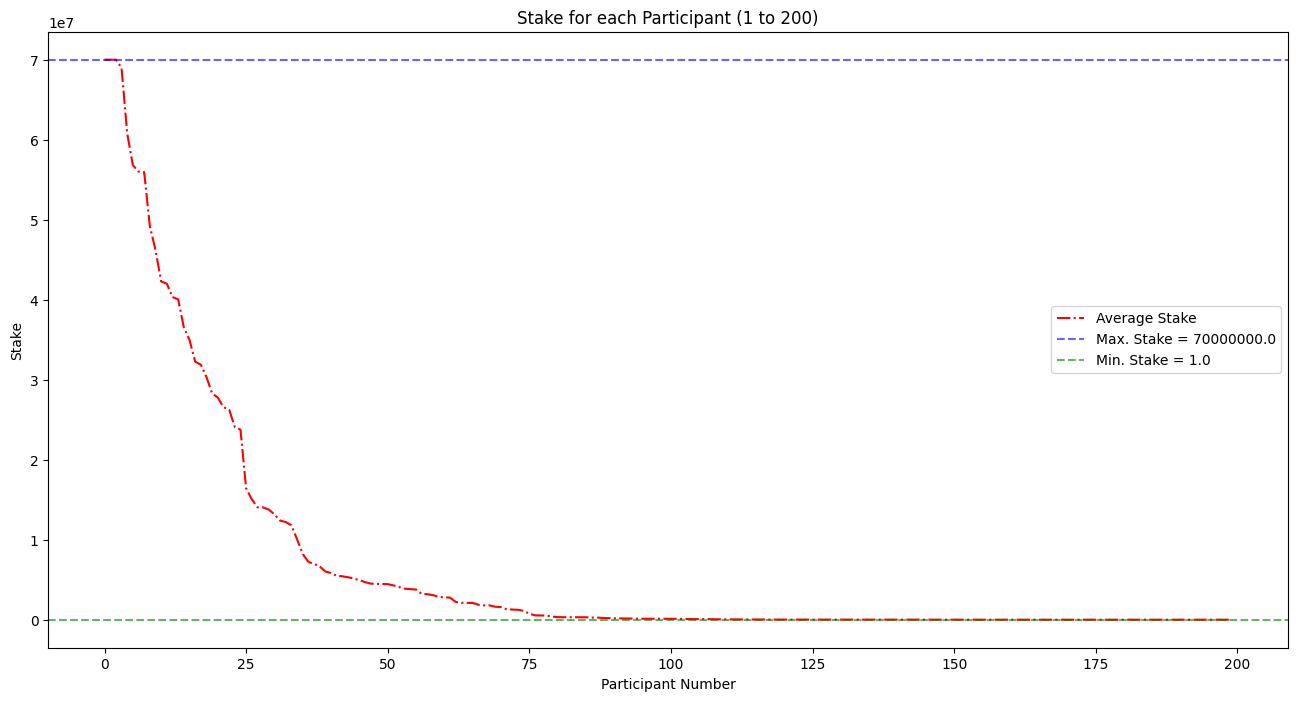

          stake  stake_weight
0    70000000.0  5.064376e-02
1    70000000.0  5.064376e-02
2    70000000.0  5.064376e-02
3    69010000.0  4.992752e-02
4    60810000.0  4.399496e-02
..          ...           ...
195         4.0  2.893929e-09
196         3.0  2.170447e-09
197         2.0  1.446965e-09
198         2.0  1.446965e-09
199         1.0  7.234824e-10

[200 rows x 2 columns]


,stake,stake_weight
count,2.000000e+02,2.000000e+02
mean,6.911019e+06,5.000000e-03
std,1.529973e+07,1.106908e-02
min,1.000000e+00,7.234824e-10
25%,1.090000e+03,7.885958e-07
50%,1.196450e+05,8.656105e-05
75%,4.455000e+06,3.223114e-03
max,7.000000e+07,5.064376e-02


In [ ]:
# %%

# Let's now sample a group of participants from the population
# and calculate the stake weight for each participant.

group_size = 200

group_stakes = get_stake_distribution(
    population,
    group_size=group_size,
    num_iter=1,
    plot_it=True,
)
print(group_stakes)
group_stakes.describe()

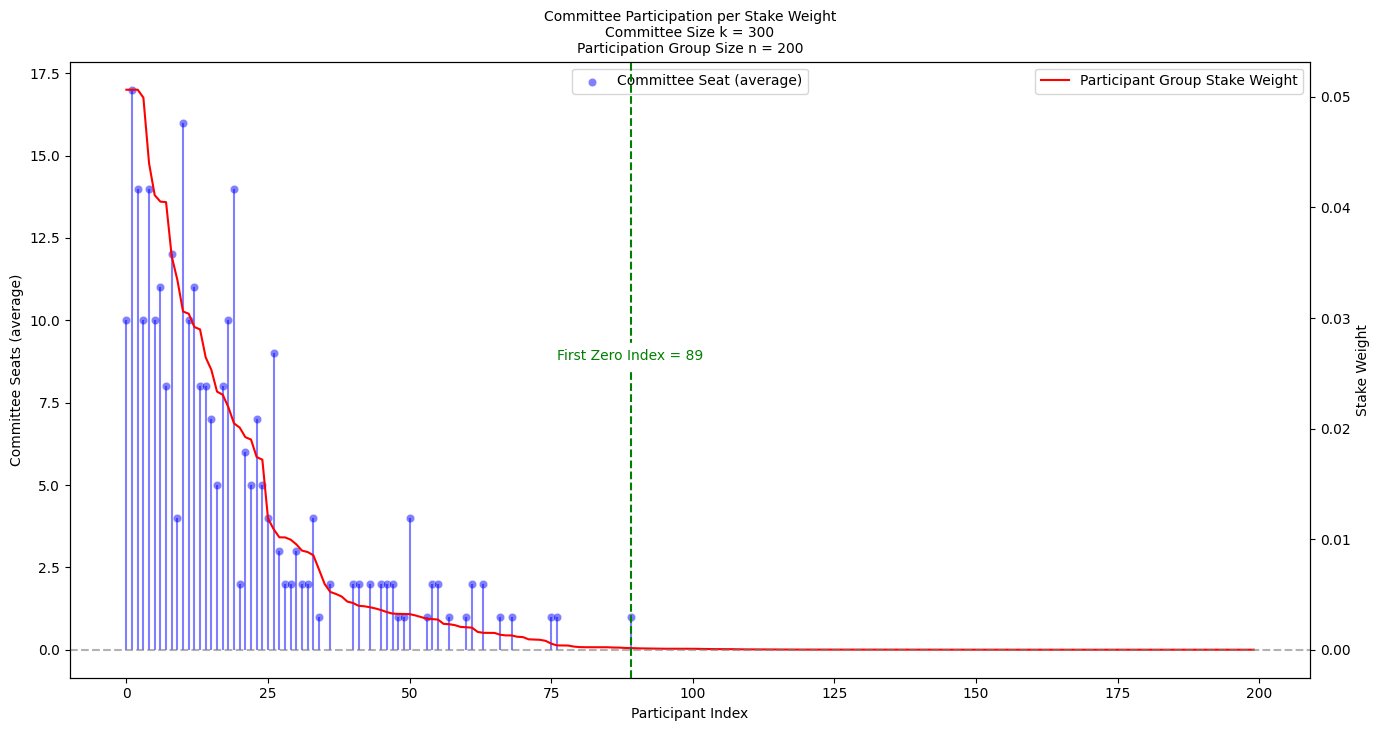

Number of distinct voters = 57


In [ ]:
# %%

# Let's test the risk_code with an example:

committee_size = 300

committee_seats = assign_commitee(
    group_stakes,
    committee_size=committee_size,
    plot_it=True,
)
print(
    "Number of distinct voters =",
    len(committee_seats[committee_seats > 0]),
)

In [ ]:
# %%

# Fault tolerance probability without federated nodes
f = 7  # fault appetite
p = calculate_fault_tolerance_probability(
    participant_group=group_stakes,
    committee_size=committee_size,
    fault_tolerance=f,
)

print(
    f"Probability of tolerating {f} faults in a "
    f"committee of size {committee_size} = {p:.2}"
)

Monte Carlo Simulation: 100%|██████████| 1000/1000 [00:03<00:00, 285.54it/s]

Probability of tolerating 7 faults in a committee of size 300 = 0.17


In [ ]:
# %%

# Fault tolerance probability with federated nodes
f = 7  # fault appetite
p = calculate_fault_tolerance_probability(
    participant_group=group_stakes,
    committee_size=committee_size,
    num_federated=10,
    seats_per_federated=8,
    fault_tolerance=f,
)

print(
    f"With federated nodes (num_federated = 10, seats_per_federated = 8):\n"
    f"Probability of tolerating {f} faults in a "
    f"committee of size {committee_size} = {p:.2}\n"
)

Monte Carlo Simulation: 100%|██████████| 1000/1000 [00:03<00:00, 307.97it/s]

With federated nodes (num_federated = 10, seats_per_federated = 8):
Probability of tolerating 7 faults in a committee of size 300 = 1.0



Monte Carlo Simulation: 100%|██████████| 1000/1000 [00:09<00:00, 107.79it/s]


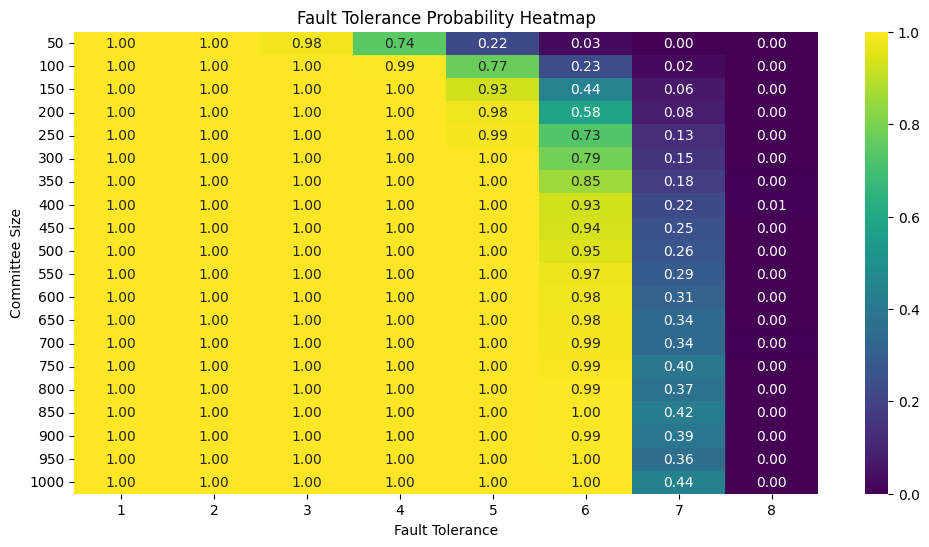

Fault Tolerance,1,2,3,4,5,6,7,8
Committee Size,,,,,,,,
50,1.0,0.999,0.982,0.743,0.221,0.026,0.003,0.000
100,1.0,1.000,1.000,0.993,0.772,0.234,0.024,0.001
150,1.0,1.000,1.000,1.000,0.929,0.444,0.064,0.001
200,1.0,1.000,1.000,1.000,0.979,0.580,0.082,0.001
250,1.0,1.000,1.000,1.000,0.988,0.729,0.129,0.002
300,1.0,1.000,1.000,1.000,0.999,0.787,0.148,0.003
350,1.0,1.000,1.000,1.000,0.999,0.854,0.179,0.004
400,1.0,1.000,1.000,1.000,1.000,0.928,0.222,0.006
450,1.0,1.000,1.000,1.000,1.000,0.935,0.247,0.001


In [ ]:
# %%

plot_fault_tolerance_heatmap(
    participant_group=group_stakes,
    committee_sizes=np.arange(50, 1050, 50),
    fault_tolerance=np.arange(1, 9, 1),
    plot_it=True,
    figsize=(12, 6),
)

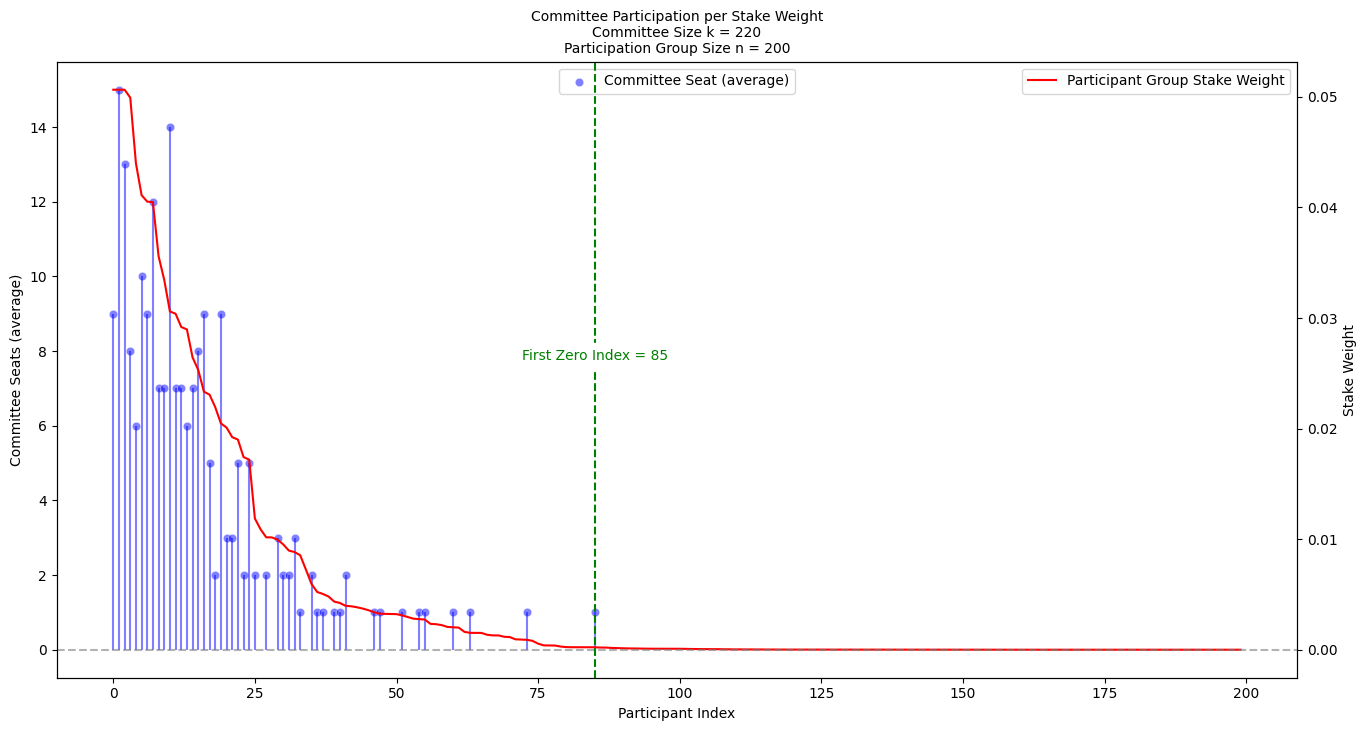

Committee size .... = 300 
________________________________________
Permissioned:Number of seats = 220 
Number of nodes = 200 
voting strength = 73.33% 
________________________________________
Federated:Number of seats = 80 
Seats per node  = 8 
Number of nodes = 10 
Voting strength = 26.67%


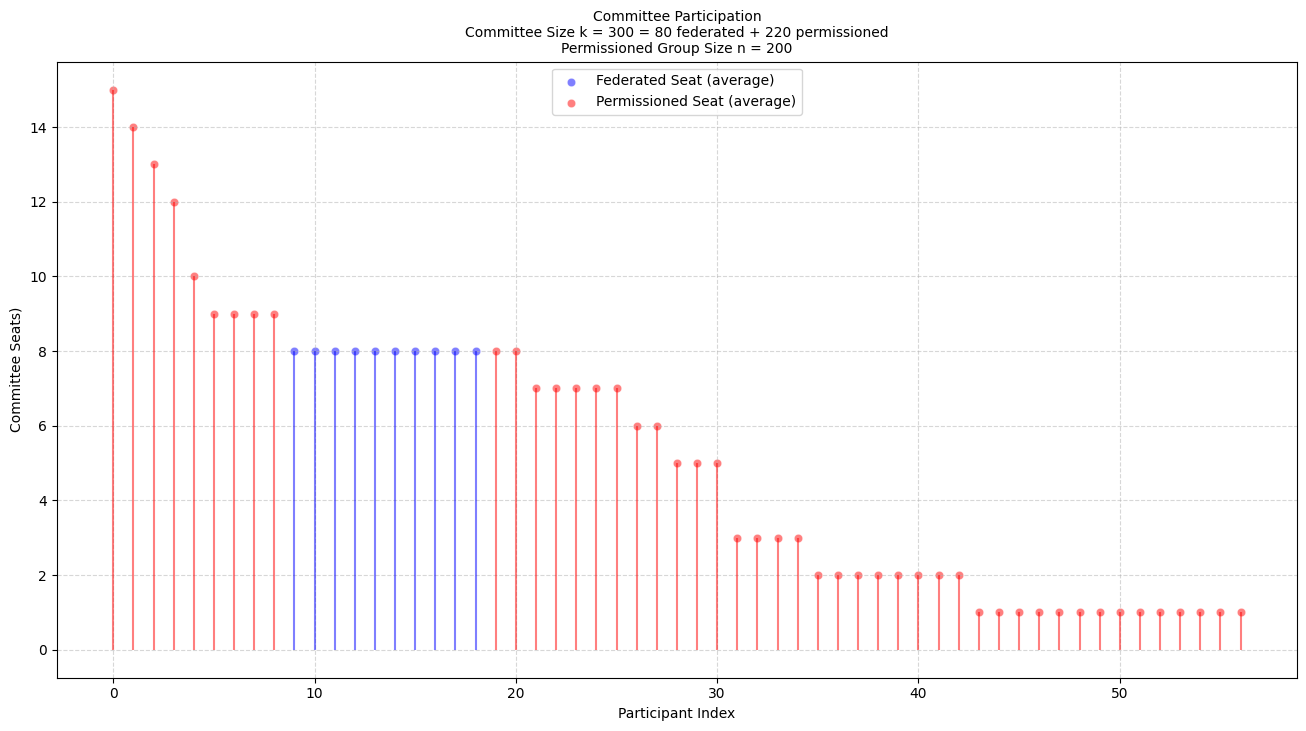

In [ ]:
# %%

# Introduce federated participants
committee_seats = assign_committee_seats(
    group_stakes,
    committee_size=committee_size,
    num_federated=10,
    seats_per_federated=8,
    plot_it=True,
    verbose=True,
)

# Plot the committee seats distribution
plot_committee_seats(committee_seats)

In [ ]:
# %%

committee_seats.head(50)

,kind,seats
index,,
1,permissioned,15
10,permissioned,14
2,permissioned,13
7,permissioned,12
5,permissioned,10
0,permissioned,9
6,permissioned,9
16,permissioned,9
19,permissioned,9


In [ ]:
# %%

# Fault tolerance probability WITHOUT federated nodes
ft_without_feds = print_fault_tolerance_table(
    group_stakes,
    committee_size=300,
    fault_levels=[1, 2, 3, 4, 5, 6, 7, 8],
    verbose=True,
)

--------------------------------------------------------
• Group size 200
• Committee size 300
• 0 federated nodes
• 0 seats per federated node
• Fault levels [1, 2, 3, 4, 5, 6, 7, 8]
--------------------------------------------------------



Calculating fault tolerance: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


In [ ]:
# %%

# Fault tolerance probability WITH federated nodes
ft_with_feds = print_fault_tolerance_table(
    group_stakes,
    committee_size=300,
    num_federated=5,
    seats_per_federated=5,
    fault_levels=[1, 2, 3, 4, 5, 6, 7, 8],
    verbose=True,
)

--------------------------------------------------------
• Group size 200
• Committee size 300
• 5 federated nodes
• 5 seats per federated node
• Fault levels [1, 2, 3, 4, 5, 6, 7, 8]
--------------------------------------------------------



Calculating fault tolerance: 100%|██████████| 8/8 [00:28<00:00,  3.52s/it]


In [ ]:
# %%

ft = pd.concat(
    [ft_without_feds, ft_with_feds],
    axis=1,
    keys=["Without Federated Nodes", "With Federated Nodes"],
).style.format("{:.2}")

ft

,Without Federated Nodes,With Federated Nodes
,Probability,Probability
Fault Level,,
f = 1,1.0,1.0
f = 2,1.0,1.0
f = 3,1.0,1.0
f = 4,1.0,1.0
f = 5,1.0,1.0
f = 6,0.78,0.99
f = 7,0.17,0.63
f = 8,0.001,0.065
